<a id='section1'></a>
<div class="alert alert-block alert-info">
Jump to:<br>
    <a href='#section2'>Temperature experiment allele counts by filtering method</a><br>
    <a href='#todo'>To Do list</a><br>
    <a href='#section99'>Bottom</a><br>
</div>

# PIRE temperature experiment data exploration and analysis
---

#### First, explore and filter the data for total SNP coverage and minimum SNP frequency. Then, run analyses on experimental effects and combine data as necessary.

Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv

import statsmodels.api as sm
import statsmodels.formula.api as sf
import matplotlib.pyplot as plt

In [2]:
from pi_for_temperature_notebook import *

Check module versions. <br>Versions of modules used while developing this code:<br>
Pandas: 1.0.1<br>
Numpy: 1.18.1<br>
statsmodels: 0.11.0<br>
Matplotlib: 3.1.3

In [3]:
print("Local versions:\nPandas: "+str(pd.__version__))
print("Numpy: "+str(np.__version__))
print("Statsmodels: "+str(sm.__version__))
print("Matplotlib: "+mpv)

Local versions:
Pandas: 1.0.1
Numpy: 1.18.1
Statsmodels: 0.11.0
Matplotlib: 3.1.3


Load table data of gene and 5' intergenic region coordinates:

In [4]:
region_info = pd.read_csv("ACMV_EACMCV_regions.csv",header=0,index_col=False)

Load temperature experiment data:

In [14]:
raw_data = pd.read_csv("variant-calls_temperature-expt_2020-04-07_tables.csv",header=0,index_col=0)
print("Total variants in the VarScan output: {:,}".format(raw_data.shape[0]))

Total variants in the VarScan output: 62,448


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<div class="alert alert-block alert-warning">Some 32$^{o}$ sample rows are problematic. We'll keep the data file as-is and filter out the 32$^{o}$ data here to reduce data storage clutter. After removing the 32$^{o}$ rows, we will have to define the data types (`dtypes`) for the two rows mentioned in the warning above.</div>

Remove rows for 32$^{o}$ data samples. 

In [15]:
no_32_data = raw_data.loc[raw_data.temperature != 32]

We'll ignore resetting dtypes for the two columns because we will not use column 9 and will recalculate column 58 later. To set dtype for columns 9 (`directVegParent`) and 58 (`DP`), use the following code: 
```
filtered_data.directVegParent = filtered_data.directVegParent.astype(str)
filtered_data.DP = filtered_data.DP.astype(int)
```

We have technical replicates A and B for samples. Here are scatter plots of total coverage and alternate allele frequency between replicates:

Text(0.5, 0.98, 'Total SNP coverage between technical replicates')

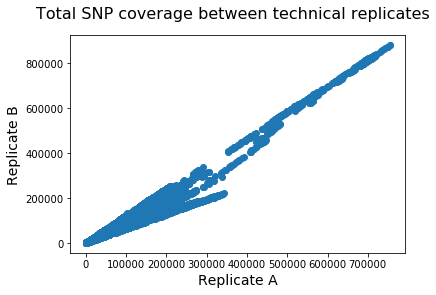

In [7]:
plt.scatter(x='DPReplicateA',y='DPReplicateB',data=no_32_data)
plt.xlabel('Replicate A',fontsize=14)
plt.ylabel('Replicate B',fontsize=14)
plt.title('')
plt.suptitle('Total SNP coverage between technical replicates',fontsize=16)

Text(0.5, 0.98, 'Alternate SNP frequency between technical replicates')

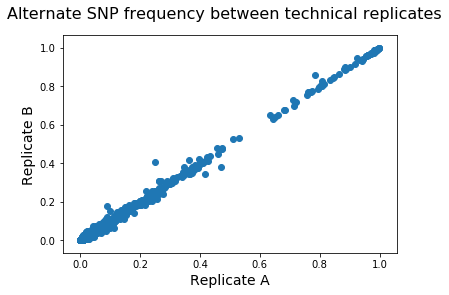

In [8]:
plt.scatter(x='freqPropReplicateA',y='freqPropReplicateB',data=no_32_data)
plt.xlabel('Replicate A',fontsize=14)
plt.ylabel('Replicate B',fontsize=14)
plt.title('')
plt.suptitle('Alternate SNP frequency between technical replicates',fontsize=16)

Total coverage and alternate allele frequency correlate nicely between. SNPs that are detected are not shown in these plots. Let's remove them: 

In [16]:
both_replicates = no_32_data.dropna(subset=['DPReplicateA','DPReplicateB'])

Let's check how setting a minimum coverage of 100 on both replicates affects SNP count:

In [10]:
print("Total SNPs:")
print("Filtered, no minimum: {:,}".format(both_replicates.shape[0]))
min_coverage = both_replicates.loc[both_replicates.DPReplicateA >= 100]
min_coverage = min_coverage.loc[min_coverage.DPReplicateB >= 100]
print("Filtered, minimum total coverage 100: {:,}".format(min_coverage.shape[0]))

Total SNPs:
Filtered, no minimum: 29,374
Filtered, minimum total coverage 100: 29,369


Define a function to return the total number of rows after filtering for minimum SNP frequency in at least one technical replicate:

In [19]:
def snp_count(data, minimum=0.01, freq1='freqPropReplicateA', freq2='freqPropReplicateB'):
    
    temp = pd.concat([data.loc[data[freq1] >= minimum],data.loc[data[freq2] >= minimum]]).drop_duplicates()
    return temp.shape[0]

Let's look at how minimum SNP frequency in at least one technical replicate:

Text(0.5, 0.98, 'Total SNP count across minimum cutoff values')

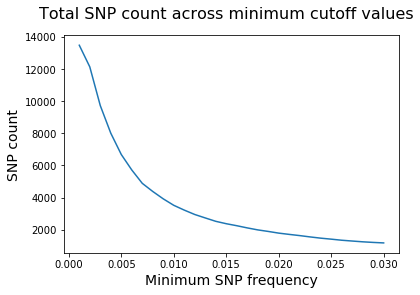

In [20]:
x = [i/1000 for i in range(1,31)]
y = [snp_count(both_replicates,j) for j in x]
plt.plot(x,y)
plt.xlabel("Minimum SNP frequency",fontsize=14)
plt.ylabel("SNP count",fontsize=14)
plt.suptitle("Total SNP count across minimum cutoff values",fontsize=16)

Define a function to filter the data by minimum SNP frequency in at least one technical replicate:

In [13]:
def min_snp_freq(data, minimum=0.01, freq1='freqPropReplicateA', freq2='freqPropReplicateB'):
    
    temp = pd.merge(data.loc[data[freq1] >= minimum],data.loc[data[freq2] >= minimum],how='outer')
    return temp

<strike>Let's use minimum coverage of 100 for both technical replicates and a minimum SNP frequency of 3% in at least one technical replicate:</strike>

In [ ]:
#min_filtered_data = min_snp_freq_data(both_replicates, 0.03)
#min_filtered_data.sort_values(by='chrom',inplace=True)

The columns of interest for the analysis are `temperature`, `passage`, `lineage`, and `chrom`. We'll seperate `chrom` to two columns, one for the species and another for the segment. We'll also code lineage to numeric values and keep in mind that lineage, species, and segment are categorical data.

In [ ]:
def factorize(data,column):
    
    column_ids = data[column].unique().tolist()
    factor = [column_ids.index(x) for x in data[column]]
    return factor

In [ ]:
filtered_data = min_snp_freq(both_replicates,minimum=0.03)

filtered_data['lineage_factor'] = factorize(filtered_data,'lineage')

#set species as 1 for EACMCV, 0 represents ACMV
filtered_data['species'] = 0
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-A','species'] = 1
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-B','species'] = 1

#set segment as 0 for DNA-A, 1 for DNA-B
filtered_data['segment'] = 0
filtered_data.loc[filtered_data.chrom == 'ACMV DNA-B','segment'] = 1
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-B','segment'] = 1

#ACMV can be extracted as value 0 in column `species`; let's check segment factor values
print("Chrom\t\tspecies\tsegment")
for seg in filtered_data.chrom.unique():
    temp = filtered_data.loc[filtered_data.chrom == seg]
    print(seg+":\t{}\t{}".format(temp.species.unique(),temp.segment.unique()))

Load functions for calculating pi and the variance of pi. Make sure that the file `pi_for_temperature_notebook.py` is saved in the same folder as this Jupyter notebook.

In [ ]:
#we need to load and set a dictionary of options for use with the pi_for_temperature_notebook.py functions
options = get_temp_args()
options['perSite'] = False

In [ ]:
#set up local functions to group our data sets and call the loaded pi_for_temperature_notebook.py functions
def build_pi_df(pis,groupby):
    
    pis_dict = {}
    
    for group in groupby:
        
        pis_dict[group] = []
        
    pis_dict['pi'] = []
    
    for key in pis.keys():
        pis_dict['pi'].append(pis[key][0])
        for i in range(len(groupby)):
            pis_dict[groupby[i]].append(key[i])
            
    df = pd.DataFrame.from_dict(pis_dict, orient='columns')
    
    return df
    

def get_group_pis(data,options,group_by):
    
    pis_func = {}
    
    grouped_data = data.groupby(by=group_by)
    
    for group in grouped_data:
    
        try:
            N_samples = int(group[1][options['coverage']].mean())
        except:
            N_samples = False
              
        pis_func[group[0]] = pi(pi_data=group[1],
            sites=(1, group[1][options['position']].max()),
            N_samples=N_samples,
            pos_id=options['position'],
            Reference=options['reference'],
            Alternate=options['alternate'],
            frequency=options['frequency'],
            correction=options['sizeCorrection'],
            per_site=options['perSite'],
            sampling_variance=options['sampling_variance'],
            lngth=options['length'])
    
    return build_pi_df(pis_func,group_by)

In [ ]:
#set ReplicateA specific options
options['coverage'] = 'DPReplicateA'
options['frequency'] = 'freqPropReplicateA'


#get the ReplicateA pi for groups
pis_A = get_group_pis(filtered_data,
                     options=options,
                     group_by=['passage','temperature','species','segment','lineage_factor'])

#set replicate factor value
pis_A['Replicate'] = 0

#calculate pi for ReplicateB
options['coverage'] = 'DPReplicateB'
options['frequency'] = 'freqPropReplicateB'

pis_B = get_group_pis(filtered_data,
                     options=options,
                     group_by=['passage','temperature','species','segment','lineage_factor'])

#set replicate factor value
pis_B['Replicate'] = 1

#concatenate the two dataframes
pi_df = pd.concat([pis_A,pis_B])


In [ ]:
pi_df.columns

Run the ANOVA

In [ ]:
lm = sf.ols('pi ~ passage + temperature + C(species)/C(segment) + C(lineage_factor) + C(Replicate)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())
table = sm.stats.anova_lm(lm)
print("\nANOVA table:")
print(table)

In [ ]:
#lets drop replicate from the model
lm = sf.ols('pi ~ passage + temperature + C(species)/C(segment) + C(lineage_factor)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())
table = sm.stats.anova_lm(lm)
print("\nANOVA table:")
print(table)

In [ ]:
#let's drop temperature
lm = sf.ols('pi ~ passage + C(species)/C(segment) + C(lineage_factor)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())
table = sm.stats.anova_lm(lm)
print("\nANOVA table:")
print(table)

In [ ]:
#let's drop lineage
lm = sf.ols('pi ~ passage + C(species)/C(segment)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())
table = sm.stats.anova_lm(lm)
print("\nANOVA table:")
print(table)

Let's visualize what's going on with these groups

In [ ]:
pi_df.boxplot(by='passage',column='pi',patch_artist=True,grid=False)
plt.ylabel('pi',fontsize=14)
plt.xlabel('passage',fontsize=14)

In [ ]:
pi_df.boxplot(by=['species','segment'],column='pi',patch_artist=True,grid=False)
x_ticks = plt.xticks()
plt.xticks(x_ticks[0],['ACMV-A','ACMV-B','EACMCV-A','EACMCV-B'])
plt.xlabel('segment',fontsize=14)
plt.ylabel('pi',fontsize=14)

In [ ]:
pi_df.boxplot(by='lineage_factor',column='pi',patch_artist=True,grid=False)

<a id='section2'></a>
<a id='section1'></a>
<div class="alert alert-block alert-info">
Jump to:<br>
    <a href='#section1'>PIRE temperature experiment data exploration and analysis (top)</a><br>
    <a href='#section99'>Bottom</a><br>
</div>

# Temperature experiment allele counts by filtering method
---
We are going to first count the number of multiallelic sites within unique plants, then within groups of plants.

[Dan Koboldt's 2012 comment on the `readcounts` utility](https://sourceforge.net/p/varscan/discussion/1073559/thread/c647b0ba/#2acb)

Load necessary package(s) and temperature experiment data:

In [ ]:
data = pd.read_csv("variant-calls_temperature-expt_2020-04-07_tables.csv",
                   header=0,
                   index_col=0)

<div class="alert alert-block alert-warning">
<b>Note:</b> The above warning stems from incomplete data in rows from the 32$^{o}$ data, which we will remove.
</div>

In [ ]:
#remove 32 degree data
data = data.loc[data.temperature != 32]

#fix the data types for the two problemmatic columns
data.directVegParent = data.directVegParent.astype(str)
data.DP = data.DP.astype(int)

Define a function to return a dictionary of counts of sites with $X$ alleles 

In [ ]:
def get_allele_counts(data):
    #initialize variables to hold working data
    running_allele_counts = []
    count_data = {}
    
    #count alleles per site by unique plant ID
    for plant in data.plantID.unique():
        plant_data =  data.loc[data.plantID == plant]
        for position in plant_data.pos.unique():
            running_allele_counts.append(plant_data.loc[plant_data.pos == position].shape[0])
    
    #count the number of sites with i _alternate_ alleles;
    #add 1 to dictionary index to represent _total_ alleles per site
    for i in range(1,max(running_allele_counts)+1):        
        count_data[i+1] = running_allele_counts.count(i)
        
    #return the dictionary    
    return count_data

def print_counts(data):
    
    #print the allele counts nicely
    print("Alleles/site\t# Observed")
    for count in data.keys():
        print("{}\t\t{}".format(count,data[count]))
    return

In [ ]:
raw_allele_counts = get_allele_counts(data)

In [ ]:
print_counts(raw_allele_counts)

Remove the alleles with no representation in one technical replicate: 

In [ ]:
no_na_data = data.dropna(subset=['DPReplicateA','DPReplicateB'])

In [ ]:
no_na_counts = get_allele_counts(no_na_data)

In [ ]:
print_counts(no_na_counts)

#### Filter alleles by minimum 3% in at least one technical replicate, and present in the other

In [ ]:
min_3percent = pd.merge(no_na_data.loc[no_na_data.freqPropReplicateA >= 0.03],
                        no_na_data.loc[no_na_data.freqPropReplicateB >= 0.03],
                        how='outer')

min_3percent.drop_duplicates(inplace=True)
min_3percent_allele_counts = get_allele_counts(min_3percent)
print_counts(min_3percent_allele_counts)

Let's look at how minimum frequency cutoff affects max allele count per site

In [ ]:
def min_snp_freq_data(data, minimum=0.01, freq1='freqPropReplicateA', freq2='freqPropReplicateB'):
    
    temp = pd.merge(data.loc[data[freq1] >= minimum],data.loc[data[freq2] >= minimum],how='outer')
    return temp

In [ ]:
x = [i/1000 for i in range(0,31)]
y = [max(get_allele_counts(min_snp_freq_data(no_na_data,j))) for j in x]

In [ ]:
plt.plot(x,y)
plt.xlabel("Minimum SNP frequency",fontsize=14)
plt.ylabel("Max allele count",fontsize=14)
plt.suptitle("Maximum allele count across minimum cutoff values",fontsize=16)
plt.title("Alleles represented in both tech reps")

In [ ]:
x_r = [i/1000 for i in range(0,31)]
y_r = [max(get_allele_counts(min_snp_freq_data(data,j))) for j in x_r]

In [ ]:
plt.plot(x_r,y_r)
plt.xlabel("Minimum SNP frequency",fontsize=14)
plt.ylabel("Max allele count",fontsize=14)
plt.suptitle("Maximum allele count across minimum cutoff values",fontsize=16)
plt.title("Alleles represented in either tech rep")

#### Calculate a mean frequency between technical replicates and filter alleles by minimum 3% of the mean
First, use raw data and fill NA's with zeros then filter by minimum 3% average

In [ ]:
#fill the NAs of the frequency columns with zeros
data.freqPropReplicateA.fillna(0)
data.freqPropReplicateB.fillna(0)

#generate an average frequency proportion column (simple)
data['meanFreqProp'] = data[['freqPropReplicateA','freqPropReplicateB']].mean(axis=1)

#count the sites with X alleles
mean_3percent = data.loc[data.meanFreqProp >= 0.03]
mean_3percent_allele_counts = get_allele_counts(mean_3percent)
print_counts(mean_3percent_allele_counts)

#### Calculate a mean frequency between technical replicates after having dropped alleles with no representation in one technical replicate

In [ ]:
#generate an average frequency proportion column (must be present in both tech reps)
no_na_data.meanFreqProp = no_na_data[['freqPropReplicateA','freqPropReplicateB']].mean(axis=1)

#count the sites with X alleles
mean_3percent_no_na = no_na_data.loc[no_na_data.meanFreqProp >= 0.03]
mean_3percent_no_na_allele_counts = get_allele_counts(mean_3percent_no_na)
print_counts(mean_3percent_no_na_allele_counts)

<a id='section99'></a>
<div class="alert alert-block alert-info">
Jump to:<br>
     <a href='#section1'>PIRE temperature experiment data exploration and analysis (top)</a><br>
    <a href='#section2'>Temperature experiment allele counts by filtering method</a><br>
    <a href='#section99'>Bottom</a><br>
</div>

<a id='todo'></a>
##### To Do:
<br>
1. Run Waterson's theta at 1% minimum cutoff
2. SNP count for 1% both, 3% both, 3% in one and represented in other
3. Waterson's theta for all, tajima's D for all
4. Wateron's theta/Tajima's D for range of cutoff values. 